In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.models import resnet18
import os
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import torch
import math

In [ ]:
__all__ = ["ResNet", "resnet50"]


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=1, stride=stride, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, include_top=True):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.include_top = include_top

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        if not self.include_top:
            return x

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def resnet50(**kwargs):
    """Constructs a ResNet-50 model."""
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

In [ ]:
def load_state_dict(model, fname):
    """
    Set parameters converted from Caffe models authors of VGGFace2 provide.
    See https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/.
    Arguments:
        model: model
        fname: file name of parameters converted from a Caffe model, assuming the file format is Pickle.
    """
    with open(fname, "rb") as f:
        weights = pickle.load(f, encoding="latin1")

    own_state = model.state_dict()
    for name, param in weights.items():
        if name in own_state:
            try:
                own_state[name].copy_(torch.from_numpy(param))
            except Exception:
                if name == "fc.weight" or "fc.bias":
                    print(name)
                    continue

                raise RuntimeError(
                    "While copying the parameter named {}, whose dimensions in the model are {} and whose "
                    "dimensions in the checkpoint are {}.".format(
                        name, own_state[name].shape, param.shape
                    )
                )
        else:
            raise KeyError('unexpected key "{}" in state_dict'.format(name))

In [ ]:
root = "/content/105_classes_pins_dataset/"

In [ ]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list


In [ ]:
def labelling_the_data(tlist):
  folders = list(tlist.keys())

  label_counter = 1

  filename =[]
  labels =[]
  for folder in folders:
      path = os.path.join(root, folder)
      files = list(os.listdir(path))
      num_files = len(files)

      for file in files:
        filename.append((folder, file))
        labels.append(label_counter)

      label_counter +=1
  
  return {"filename":filename, "labels":labels}

In [ ]:
class Create_Triplet():
    def __init__(self, df , path, transform=None):
        self.df = df
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        self.path = path
        
        self.images = df.iloc[:, 0].values
        self.labels = df.iloc[:, 1].values
        self.index = df.index.values 


    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        anchor_image_name = self.images[item]
        path = self.path
        anchor_image_path = os.path.join(root, anchor_image_name[0], anchor_image_name[1])
        ###### Anchor Image #######
        anchor_img = Image.open(anchor_image_path).convert('RGB')
        anchor_label = self.labels[item]
        
        positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]
        positive_item = random.choice(positive_list) if len(positive_list) != 0 else item
        positive_image_name = self.images[positive_item]
        positive_image_path = os.path.join(root, positive_image_name[0], positive_image_name[1])
        positive_img = Image.open(positive_image_path).convert('RGB')

        negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
        negative_item = random.choice(negative_list)
        negative_image_name = self.images[negative_item]
        negative_image_path = os.path.join(root, negative_image_name[0], negative_image_name[1])
        negative_img = Image.open(negative_image_path).convert('RGB')

        if self.transform!=None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)                 
            negative_img = self.transform(negative_img)
        return anchor_img, positive_img, negative_img, anchor_label

In [ ]:
train_list, test_list = split_dataset(root, split=0.9)
train_data = pd.DataFrame(labelling_the_data(train_list))
test_data = pd.DataFrame(labelling_the_data(test_list))

In [ ]:
def get_train_dataset():
    train_dataset = Create_Triplet(train_data,path=root,transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()]))
    return train_dataset

In [ ]:
def get_test_dataset():
    train_dataset = Create_Triplet(test_data,path=root,transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()]))
    return train_dataset

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, dist_anch_pos, dist_anch_neg) -> torch.Tensor:
        losses = torch.relu(dist_anch_pos - dist_anch_neg + self.margin)
        return losses.mean()


In [ ]:
def cal_ap_an(anchor:torch.Tensor, positive:torch.Tensor, negative:torch.Tensor):
  dist_anch_pos = (anchor-positive).pow(2).sum(1) # calculate euclidean distance 
  dist_anch_neg = (anchor-negative).pow(2).sum(1) 

  return dist_anch_pos, dist_anch_neg

In [ ]:
def cal_accuracy(dist_anch_pos,dist_anch_neg):
  accuracy = ((dist_anch_neg - dist_anch_pos) > 0).float().sum() / dist_anch_neg.size()[0]
  return accuracy.mean()

In [ ]:
def get_default_device():
#””Pick GPU if available, else CPU”””
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 20
embedding_dims = 2
DEVICE = get_default_device()

In [ ]:
train_dataset = get_train_dataset()
train_dl = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=8,pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_dataset = get_test_dataset()
test_dl = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4,pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
## try with resnet50 and weight 
##run_transfer_learning.py 

model = resnet50(num_classes=2, include_top=True)

In [ ]:
load_state_dict(model, "/content/gdrive/MyDrive/DM_Project/resnet50_ft_weight.pkl")
for params in model.parameters():
    params.requires_grad = False

model.fc.reset_parameters()

for params in model.fc.parameters():
    params.requires_grad = True

fc.weight
fc.bias


In [ ]:
# model = Network(embedding_dims)
# model.apply(init_weights)
model = model.to(DEVICE)
Optimizer = torch.optim.Adam(model.parameters(),lr = LEARNING_RATE)
criterion = torch.jit.script(TripletLoss())


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('  + Number of params: {}'.format(params))

  + Number of params: 4098


In [ ]:
def train(train_dl, model, criterion, Optimizer, epoch):

  # total_acc = 0
  # total_loss = 0 
  running_loss=[]
  accuracy_val=[]
  model.train()
  
  for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_dl, desc="Training", leave=False)):
    
    anchor_img = anchor_img.to(DEVICE)
    positive_img = positive_img.to(DEVICE)
    negative_img = negative_img.to(DEVICE)

    anchor_out = model(anchor_img)
    positive_out = model(positive_img)
    negative_out = model(negative_img)

    dist_anch_pos, dist_anch_neg = cal_ap_an(anchor_out, positive_out, negative_out)
    loss = criterion(dist_anch_pos, dist_anch_neg)
    accuracy = cal_accuracy(dist_anch_pos,dist_anch_neg)

    # compute gradient and do optimizer step
    Optimizer.zero_grad()
    loss.backward()  
    Optimizer.step()

    running_loss.append(loss.cpu().detach().numpy())
    accuracy_val.append(accuracy.cpu().detach().numpy())
    # total_acc += accuracy.item()
    # total_loss += loss.item()

    print("Epoch: {}/{} — Loss: {:.4f}".format(epoch+1, EPOCHS, np.mean(running_loss)))
    print("Accuracy:",np.mean(accuracy_val))

  return np.mean(running_loss), np.mean(accuracy_val)
  


In [ ]:
def test(test_dl, model, criterion, Optimizer, epoch):
  best_acc = 0
  max_loss = 0
  running_loss=[]
  accuracy_val=[] 
  model.eval()
  for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(test_dl, desc="Testing", leave=False)):
    
    anchor_img = anchor_img.to(DEVICE)
    positive_img = positive_img.to(DEVICE)
    negative_img = negative_img.to(DEVICE)

    anchor_out = model(anchor_img)
    positive_out = model(positive_img)
    negative_out = model(negative_img)

    dist_anch_pos, dist_anch_neg = cal_ap_an(anchor_out, positive_out, negative_out)
    loss = criterion(dist_anch_pos, dist_anch_neg)
    accuracy = cal_accuracy(dist_anch_pos,dist_anch_neg)

    running_loss.append(loss.cpu().detach().numpy())
    accuracy_val.append(accuracy.cpu().detach().numpy())

    print("Epoch: {}/{} — Loss: {:.4f}".format(epoch+1, EPOCHS, np.mean(running_loss)))
    print("Accuracy:",np.mean(accuracy_val))

  return  np.mean(running_loss),np.mean(accuracy_val)
  


In [ ]:
def save_lists_in_files(filepath, list_val):
  with open(filepath, 'w') as fp:
    for item in list_val:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

save_lists_in_files(r'/content/gdrive/MyDrive/DM_Project/train_accuracy.txt', train_accuracy)
save_lists_in_files(r'/content/gdrive/MyDrive/DM_Project/test_accuracy.txt', test_accuracy)
save_lists_in_files(r'/content/gdrive/MyDrive/DM_Project/train_loss.txt', train_loss)
save_lists_in_files(r'/content/gdrive/MyDrive/DM_Project/test_loss.txt', test_loss)

Done
Done
Done
Done


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 1/20 — Loss: 1.4584
Accuracy: 0.6875
Epoch: 1/20 — Loss: 1.4398
Accuracy: 0.6640625
Epoch: 1/20 — Loss: 1.7212
Accuracy: 0.6145833
Epoch: 1/20 — Loss: 1.6992
Accuracy: 0.60546875
Epoch: 1/20 — Loss: 1.7009
Accuracy: 0.590625
Epoch: 1/20 — Loss: 1.6605
Accuracy: 0.6145833
Epoch: 1/20 — Loss: 1.6462
Accuracy: 0.6160714
Epoch: 1/20 — Loss: 1.6055
Accuracy: 0.6152344
Epoch: 1/20 — Loss: 1.6082
Accuracy: 0.6197917
Epoch: 1/20 — Loss: 1.5356
Accuracy: 0.6375
Epoch: 1/20 — Loss: 1.5333
Accuracy: 0.6349432
Epoch: 1/20 — Loss: 1.5067
Accuracy: 0.64192706
Epoch: 1/20 — Loss: 1.4849
Accuracy: 0.6550481
Epoch: 1/20 — Loss: 1.4520
Accuracy: 0.66741073
Epoch: 1/20 — Loss: 1.4327
Accuracy: 0.67291665
Epoch: 1/20 — Loss: 1.4353
Accuracy: 0.6748047
Epoch: 1/20 — Loss: 1.4560
Accuracy: 0.6764706
Epoch: 1/20 — Loss: 1.4517
Accuracy: 0.6779514
Epoch: 1/20 — Loss: 1.4380
Accuracy: 0.68174344
Epoch: 1/20 — Loss: 1.4107
Accuracy: 0.68828124
Epoch: 1/20 — Loss: 1.3742
Accuracy: 0.69568455
Epoch: 1/20 —

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/20 — Loss: 1.4547
Accuracy: 0.765625
Epoch: 1/20 — Loss: 1.2582
Accuracy: 0.8046875
Epoch: 1/20 — Loss: 1.2744
Accuracy: 0.7864583
Epoch: 1/20 — Loss: 1.2247
Accuracy: 0.80078125
Epoch: 1/20 — Loss: 1.0879
Accuracy: 0.81875
Epoch: 1/20 — Loss: 1.0380
Accuracy: 0.8333333
Epoch: 1/20 — Loss: 1.0224
Accuracy: 0.83258927
Epoch: 1/20 — Loss: 1.0630
Accuracy: 0.83203125
Epoch: 1/20 — Loss: 1.0634
Accuracy: 0.828125
Epoch: 1/20 — Loss: 1.0670
Accuracy: 0.8328125
Epoch: 1/20 — Loss: 1.0505
Accuracy: 0.8338068
Epoch: 1/20 — Loss: 1.1162
Accuracy: 0.828125
Epoch: 1/20 — Loss: 1.0913
Accuracy: 0.828125
Epoch: 1/20 — Loss: 1.0829
Accuracy: 0.828125
Epoch: 1/20 — Loss: 1.1110
Accuracy: 0.821875
Epoch: 1/20 — Loss: 1.1323
Accuracy: 0.8154297
Epoch: 1/20 — Loss: 1.0919
Accuracy: 0.81893384
Epoch: 1/20 — Loss: 1.1583
Accuracy: 0.8151042
Epoch: 1/20 — Loss: 1.1407
Accuracy: 0.8166118
Epoch: 1/20 — Loss: 1.1547
Accuracy: 0.8125
Epoch: 1/20 — Loss: 1.1255
Accuracy: 0.8139881
Epoch: 1/20 — Loss: 

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 2/20 — Loss: 0.5368
Accuracy: 0.921875
Epoch: 2/20 — Loss: 0.4316
Accuracy: 0.921875
Epoch: 2/20 — Loss: 0.5621
Accuracy: 0.8958333
Epoch: 2/20 — Loss: 0.5660
Accuracy: 0.88671875
Epoch: 2/20 — Loss: 0.5782
Accuracy: 0.8875
Epoch: 2/20 — Loss: 0.9263
Accuracy: 0.8671875
Epoch: 2/20 — Loss: 0.9138
Accuracy: 0.86383927
Epoch: 2/20 — Loss: 0.9029
Accuracy: 0.8652344
Epoch: 2/20 — Loss: 0.8856
Accuracy: 0.8645833
Epoch: 2/20 — Loss: 0.8814
Accuracy: 0.8578125
Epoch: 2/20 — Loss: 0.8423
Accuracy: 0.8650568
Epoch: 2/20 — Loss: 0.8768
Accuracy: 0.86067706
Epoch: 2/20 — Loss: 0.8506
Accuracy: 0.86177886
Epoch: 2/20 — Loss: 0.8310
Accuracy: 0.8660714
Epoch: 2/20 — Loss: 0.8128
Accuracy: 0.865625
Epoch: 2/20 — Loss: 0.7971
Accuracy: 0.8642578
Epoch: 2/20 — Loss: 0.8277
Accuracy: 0.8630515
Epoch: 2/20 — Loss: 0.8227
Accuracy: 0.8645833
Epoch: 2/20 — Loss: 0.8236
Accuracy: 0.8659539
Epoch: 2/20 — Loss: 0.7983
Accuracy: 0.8695313
Epoch: 2/20 — Loss: 0.8030
Accuracy: 0.8697917
Epoch: 2/20 — L

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 2/20 — Loss: 0.8200
Accuracy: 0.828125
Epoch: 2/20 — Loss: 1.0633
Accuracy: 0.8046875
Epoch: 2/20 — Loss: 1.0243
Accuracy: 0.8072917
Epoch: 2/20 — Loss: 0.9938
Accuracy: 0.81640625
Epoch: 2/20 — Loss: 0.9260
Accuracy: 0.815625
Epoch: 2/20 — Loss: 0.8520
Accuracy: 0.8229167
Epoch: 2/20 — Loss: 0.8995
Accuracy: 0.82366073
Epoch: 2/20 — Loss: 0.9399
Accuracy: 0.8261719
Epoch: 2/20 — Loss: 0.9553
Accuracy: 0.8315972
Epoch: 2/20 — Loss: 0.9306
Accuracy: 0.83125
Epoch: 2/20 — Loss: 0.9704
Accuracy: 0.828125
Epoch: 2/20 — Loss: 0.9993
Accuracy: 0.82942706
Epoch: 2/20 — Loss: 1.0050
Accuracy: 0.828125
Epoch: 2/20 — Loss: 0.9955
Accuracy: 0.8292411
Epoch: 2/20 — Loss: 1.0094
Accuracy: 0.8229167
Epoch: 2/20 — Loss: 1.0393
Accuracy: 0.8183594
Epoch: 2/20 — Loss: 1.0307
Accuracy: 0.81985295
Epoch: 2/20 — Loss: 1.0610
Accuracy: 0.8177083
Epoch: 2/20 — Loss: 1.0713
Accuracy: 0.81414473
Epoch: 2/20 — Loss: 1.0988
Accuracy: 0.809375
Epoch: 2/20 — Loss: 1.0725
Accuracy: 0.8110119
Epoch: 2/20 — L

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 3/20 — Loss: 0.7479
Accuracy: 0.875
Epoch: 3/20 — Loss: 0.5258
Accuracy: 0.890625
Epoch: 3/20 — Loss: 0.8600
Accuracy: 0.859375
Epoch: 3/20 — Loss: 0.6963
Accuracy: 0.8828125
Epoch: 3/20 — Loss: 0.6640
Accuracy: 0.884375
Epoch: 3/20 — Loss: 0.6681
Accuracy: 0.8802083
Epoch: 3/20 — Loss: 0.6397
Accuracy: 0.8839286
Epoch: 3/20 — Loss: 0.6557
Accuracy: 0.88671875
Epoch: 3/20 — Loss: 0.6346
Accuracy: 0.8923611
Epoch: 3/20 — Loss: 0.5959
Accuracy: 0.8953125
Epoch: 3/20 — Loss: 0.6517
Accuracy: 0.88352275
Epoch: 3/20 — Loss: 0.6434
Accuracy: 0.88411456
Epoch: 3/20 — Loss: 0.6495
Accuracy: 0.88341343
Epoch: 3/20 — Loss: 0.6238
Accuracy: 0.8839286
Epoch: 3/20 — Loss: 0.6478
Accuracy: 0.88125
Epoch: 3/20 — Loss: 0.6287
Accuracy: 0.8828125
Epoch: 3/20 — Loss: 0.6100
Accuracy: 0.8851103
Epoch: 3/20 — Loss: 0.6123
Accuracy: 0.8854167
Epoch: 3/20 — Loss: 0.6556
Accuracy: 0.8832237
Epoch: 3/20 — Loss: 0.6340
Accuracy: 0.8851563
Epoch: 3/20 — Loss: 0.6297
Accuracy: 0.8854167
Epoch: 3/20 — Loss

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 3/20 — Loss: 1.3389
Accuracy: 0.828125
Epoch: 3/20 — Loss: 1.0047
Accuracy: 0.84375
Epoch: 3/20 — Loss: 0.9798
Accuracy: 0.859375
Epoch: 3/20 — Loss: 1.0799
Accuracy: 0.84375
Epoch: 3/20 — Loss: 1.2518
Accuracy: 0.828125
Epoch: 3/20 — Loss: 1.4447
Accuracy: 0.8098958
Epoch: 3/20 — Loss: 1.5364
Accuracy: 0.80133927
Epoch: 3/20 — Loss: 1.5393
Accuracy: 0.796875
Epoch: 3/20 — Loss: 1.6018
Accuracy: 0.7864583
Epoch: 3/20 — Loss: 1.5982
Accuracy: 0.784375
Epoch: 3/20 — Loss: 1.5762
Accuracy: 0.7855114
Epoch: 3/20 — Loss: 1.5946
Accuracy: 0.78255206
Epoch: 3/20 — Loss: 1.5990
Accuracy: 0.77884614
Epoch: 3/20 — Loss: 1.6234
Accuracy: 0.77901787
Epoch: 3/20 — Loss: 1.6061
Accuracy: 0.78333336
Epoch: 3/20 — Loss: 1.5808
Accuracy: 0.7832031
Epoch: 3/20 — Loss: 1.5553
Accuracy: 0.7840074
Epoch: 3/20 — Loss: 1.5138
Accuracy: 0.7890625
Epoch: 3/20 — Loss: 1.4841
Accuracy: 0.7919408
Epoch: 3/20 — Loss: 1.5305
Accuracy: 0.7867187
Epoch: 3/20 — Loss: 1.5354
Accuracy: 0.78571427
Epoch: 3/20 — Lo

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 4/20 — Loss: 0.8559
Accuracy: 0.90625
Epoch: 4/20 — Loss: 0.8793
Accuracy: 0.890625
Epoch: 4/20 — Loss: 0.7818
Accuracy: 0.890625
Epoch: 4/20 — Loss: 0.7164
Accuracy: 0.87890625
Epoch: 4/20 — Loss: 0.7966
Accuracy: 0.859375
Epoch: 4/20 — Loss: 0.7550
Accuracy: 0.859375
Epoch: 4/20 — Loss: 0.6855
Accuracy: 0.87053573
Epoch: 4/20 — Loss: 0.7541
Accuracy: 0.8652344
Epoch: 4/20 — Loss: 0.7868
Accuracy: 0.8663194
Epoch: 4/20 — Loss: 0.8529
Accuracy: 0.8625
Epoch: 4/20 — Loss: 0.8431
Accuracy: 0.8650568
Epoch: 4/20 — Loss: 0.8298
Accuracy: 0.8645833
Epoch: 4/20 — Loss: 0.8551
Accuracy: 0.8629808
Epoch: 4/20 — Loss: 0.8428
Accuracy: 0.86272323
Epoch: 4/20 — Loss: 0.7986
Accuracy: 0.8666667
Epoch: 4/20 — Loss: 0.8275
Accuracy: 0.8642578
Epoch: 4/20 — Loss: 0.8149
Accuracy: 0.86672795
Epoch: 4/20 — Loss: 0.7903
Accuracy: 0.8689236
Epoch: 4/20 — Loss: 0.7675
Accuracy: 0.8700658
Epoch: 4/20 — Loss: 0.7807
Accuracy: 0.8695313
Epoch: 4/20 — Loss: 0.7710
Accuracy: 0.8712798
Epoch: 4/20 — Loss

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 4/20 — Loss: 0.9315
Accuracy: 0.765625
Epoch: 4/20 — Loss: 1.4969
Accuracy: 0.7109375
Epoch: 4/20 — Loss: 1.2317
Accuracy: 0.7604167
Epoch: 4/20 — Loss: 1.1991
Accuracy: 0.796875
Epoch: 4/20 — Loss: 1.2876
Accuracy: 0.803125
Epoch: 4/20 — Loss: 1.3127
Accuracy: 0.796875
Epoch: 4/20 — Loss: 1.3743
Accuracy: 0.77678573
Epoch: 4/20 — Loss: 1.2791
Accuracy: 0.7910156
Epoch: 4/20 — Loss: 1.3168
Accuracy: 0.7951389
Epoch: 4/20 — Loss: 1.2920
Accuracy: 0.7953125
Epoch: 4/20 — Loss: 1.2559
Accuracy: 0.8025568
Epoch: 4/20 — Loss: 1.2264
Accuracy: 0.80859375
Epoch: 4/20 — Loss: 1.2147
Accuracy: 0.8088942
Epoch: 4/20 — Loss: 1.3078
Accuracy: 0.80245537
Epoch: 4/20 — Loss: 1.2685
Accuracy: 0.8052083
Epoch: 4/20 — Loss: 1.2391
Accuracy: 0.80566406
Epoch: 4/20 — Loss: 1.2705
Accuracy: 0.8014706
Epoch: 4/20 — Loss: 1.2647
Accuracy: 0.8012153
Epoch: 4/20 — Loss: 1.2665
Accuracy: 0.80263156
Epoch: 4/20 — Loss: 1.2942
Accuracy: 0.8015625
Epoch: 4/20 — Loss: 1.2732
Accuracy: 0.8020833
Epoch: 4/20 

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 5/20 — Loss: 0.3543
Accuracy: 0.90625
Epoch: 5/20 — Loss: 0.4483
Accuracy: 0.890625
Epoch: 5/20 — Loss: 0.4949
Accuracy: 0.8802083
Epoch: 5/20 — Loss: 0.5367
Accuracy: 0.890625
Epoch: 5/20 — Loss: 0.5653
Accuracy: 0.8875
Epoch: 5/20 — Loss: 0.5414
Accuracy: 0.8958333
Epoch: 5/20 — Loss: 0.5492
Accuracy: 0.90178573
Epoch: 5/20 — Loss: 0.5582
Accuracy: 0.90234375
Epoch: 5/20 — Loss: 0.5438
Accuracy: 0.90625
Epoch: 5/20 — Loss: 0.5381
Accuracy: 0.9046875
Epoch: 5/20 — Loss: 0.5616
Accuracy: 0.90340906
Epoch: 5/20 — Loss: 0.5822
Accuracy: 0.90234375
Epoch: 5/20 — Loss: 0.6307
Accuracy: 0.89783657
Epoch: 5/20 — Loss: 0.6427
Accuracy: 0.8984375
Epoch: 5/20 — Loss: 0.6244
Accuracy: 0.8989583
Epoch: 5/20 — Loss: 0.6472
Accuracy: 0.89746094
Epoch: 5/20 — Loss: 0.6711
Accuracy: 0.8961397
Epoch: 5/20 — Loss: 0.6678
Accuracy: 0.8958333
Epoch: 5/20 — Loss: 0.6816
Accuracy: 0.8947368
Epoch: 5/20 — Loss: 0.6886
Accuracy: 0.8929688
Epoch: 5/20 — Loss: 0.6913
Accuracy: 0.8936012
Epoch: 5/20 — Lo

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 5/20 — Loss: 0.9543
Accuracy: 0.84375
Epoch: 5/20 — Loss: 1.1887
Accuracy: 0.8359375
Epoch: 5/20 — Loss: 1.4607
Accuracy: 0.8177083
Epoch: 5/20 — Loss: 1.4765
Accuracy: 0.81640625
Epoch: 5/20 — Loss: 1.3783
Accuracy: 0.828125
Epoch: 5/20 — Loss: 1.2947
Accuracy: 0.8307292
Epoch: 5/20 — Loss: 1.2810
Accuracy: 0.8191964
Epoch: 5/20 — Loss: 1.3322
Accuracy: 0.8183594
Epoch: 5/20 — Loss: 1.3131
Accuracy: 0.8125
Epoch: 5/20 — Loss: 1.2805
Accuracy: 0.8140625
Epoch: 5/20 — Loss: 1.3595
Accuracy: 0.81107956
Epoch: 5/20 — Loss: 1.2731
Accuracy: 0.8203125
Epoch: 5/20 — Loss: 1.2322
Accuracy: 0.82211536
Epoch: 5/20 — Loss: 1.2654
Accuracy: 0.8136161
Epoch: 5/20 — Loss: 1.2353
Accuracy: 0.81666666
Epoch: 5/20 — Loss: 1.2156
Accuracy: 0.82128906
Epoch: 5/20 — Loss: 1.2015
Accuracy: 0.82077205
Epoch: 5/20 — Loss: 1.2967
Accuracy: 0.8159722
Epoch: 5/20 — Loss: 1.3025
Accuracy: 0.81085527
Epoch: 5/20 — Loss: 1.2900
Accuracy: 0.8125
Epoch: 5/20 — Loss: 1.2860
Accuracy: 0.8110119
Epoch: 5/20 — L

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 6/20 — Loss: 0.5743
Accuracy: 0.90625
Epoch: 6/20 — Loss: 0.6436
Accuracy: 0.9140625
Epoch: 6/20 — Loss: 0.5883
Accuracy: 0.9114583
Epoch: 6/20 — Loss: 0.4937
Accuracy: 0.91796875
Epoch: 6/20 — Loss: 0.5708
Accuracy: 0.91875
Epoch: 6/20 — Loss: 0.5606
Accuracy: 0.9166667
Epoch: 6/20 — Loss: 0.6968
Accuracy: 0.90178573
Epoch: 6/20 — Loss: 0.7092
Accuracy: 0.90234375
Epoch: 6/20 — Loss: 0.6932
Accuracy: 0.9010417
Epoch: 6/20 — Loss: 0.6912
Accuracy: 0.903125
Epoch: 6/20 — Loss: 0.7296
Accuracy: 0.8948864
Epoch: 6/20 — Loss: 0.6849
Accuracy: 0.9010417
Epoch: 6/20 — Loss: 0.6663
Accuracy: 0.9026442
Epoch: 6/20 — Loss: 0.6590
Accuracy: 0.90066963
Epoch: 6/20 — Loss: 0.6530
Accuracy: 0.9010417
Epoch: 6/20 — Loss: 0.6440
Accuracy: 0.9013672
Epoch: 6/20 — Loss: 0.6206
Accuracy: 0.9016544
Epoch: 6/20 — Loss: 0.6209
Accuracy: 0.9001736
Epoch: 6/20 — Loss: 0.6175
Accuracy: 0.8996711
Epoch: 6/20 — Loss: 0.6015
Accuracy: 0.9015625
Epoch: 6/20 — Loss: 0.6025
Accuracy: 0.90029764
Epoch: 6/20 —

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 6/20 — Loss: 0.9780
Accuracy: 0.8125
Epoch: 6/20 — Loss: 0.9920
Accuracy: 0.8203125
Epoch: 6/20 — Loss: 1.0791
Accuracy: 0.8177083
Epoch: 6/20 — Loss: 1.0502
Accuracy: 0.82421875
Epoch: 6/20 — Loss: 1.0417
Accuracy: 0.821875
Epoch: 6/20 — Loss: 1.0647
Accuracy: 0.8255208
Epoch: 6/20 — Loss: 1.1999
Accuracy: 0.828125
Epoch: 6/20 — Loss: 1.2571
Accuracy: 0.8339844
Epoch: 6/20 — Loss: 1.2193
Accuracy: 0.8333333
Epoch: 6/20 — Loss: 1.1722
Accuracy: 0.8375
Epoch: 6/20 — Loss: 1.1807
Accuracy: 0.83096594
Epoch: 6/20 — Loss: 1.2187
Accuracy: 0.82161456
Epoch: 6/20 — Loss: 1.2143
Accuracy: 0.82091343
Epoch: 6/20 — Loss: 1.2210
Accuracy: 0.81473213
Epoch: 6/20 — Loss: 1.2274
Accuracy: 0.81666666
Epoch: 6/20 — Loss: 1.2329
Accuracy: 0.8154297
Epoch: 6/20 — Loss: 1.2315
Accuracy: 0.8125
Epoch: 6/20 — Loss: 1.2069
Accuracy: 0.8142361
Epoch: 6/20 — Loss: 1.1693
Accuracy: 0.81825656
Epoch: 6/20 — Loss: 1.1733
Accuracy: 0.81875
Epoch: 6/20 — Loss: 1.1719
Accuracy: 0.81845236
Epoch: 6/20 — Loss

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 7/20 — Loss: 0.8683
Accuracy: 0.859375
Epoch: 7/20 — Loss: 0.8521
Accuracy: 0.8671875
Epoch: 7/20 — Loss: 0.7746
Accuracy: 0.8854167
Epoch: 7/20 — Loss: 0.6625
Accuracy: 0.890625
Epoch: 7/20 — Loss: 0.6213
Accuracy: 0.884375
Epoch: 7/20 — Loss: 0.6235
Accuracy: 0.8828125
Epoch: 7/20 — Loss: 0.6319
Accuracy: 0.87946427
Epoch: 7/20 — Loss: 0.6002
Accuracy: 0.8886719
Epoch: 7/20 — Loss: 0.5963
Accuracy: 0.890625
Epoch: 7/20 — Loss: 0.5999
Accuracy: 0.890625
Epoch: 7/20 — Loss: 0.5830
Accuracy: 0.890625
Epoch: 7/20 — Loss: 0.6342
Accuracy: 0.8828125
Epoch: 7/20 — Loss: 0.6051
Accuracy: 0.88822114
Epoch: 7/20 — Loss: 0.5855
Accuracy: 0.88839287
Epoch: 7/20 — Loss: 0.5972
Accuracy: 0.88645834
Epoch: 7/20 — Loss: 0.5989
Accuracy: 0.8857422
Epoch: 7/20 — Loss: 0.5793
Accuracy: 0.8869485
Epoch: 7/20 — Loss: 0.6031
Accuracy: 0.8862847
Epoch: 7/20 — Loss: 0.6258
Accuracy: 0.88898027
Epoch: 7/20 — Loss: 0.6548
Accuracy: 0.8882812
Epoch: 7/20 — Loss: 0.6597
Accuracy: 0.8876488
Epoch: 7/20 — 

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 7/20 — Loss: 2.2315
Accuracy: 0.828125
Epoch: 7/20 — Loss: 1.5111
Accuracy: 0.8515625
Epoch: 7/20 — Loss: 1.5305
Accuracy: 0.8489583
Epoch: 7/20 — Loss: 1.4635
Accuracy: 0.84375
Epoch: 7/20 — Loss: 1.4006
Accuracy: 0.8375
Epoch: 7/20 — Loss: 1.4846
Accuracy: 0.828125
Epoch: 7/20 — Loss: 1.4373
Accuracy: 0.8348214
Epoch: 7/20 — Loss: 1.4141
Accuracy: 0.8378906
Epoch: 7/20 — Loss: 1.4274
Accuracy: 0.8315972
Epoch: 7/20 — Loss: 1.4508
Accuracy: 0.83125
Epoch: 7/20 — Loss: 1.4109
Accuracy: 0.83522725
Epoch: 7/20 — Loss: 1.4306
Accuracy: 0.8307292
Epoch: 7/20 — Loss: 1.3660
Accuracy: 0.83413464
Epoch: 7/20 — Loss: 1.3648
Accuracy: 0.8348214
Epoch: 7/20 — Loss: 1.3582
Accuracy: 0.8333333
Epoch: 7/20 — Loss: 1.3412
Accuracy: 0.8310547
Epoch: 7/20 — Loss: 1.3185
Accuracy: 0.8318015
Epoch: 7/20 — Loss: 1.3757
Accuracy: 0.8315972
Epoch: 7/20 — Loss: 1.3781
Accuracy: 0.8355263
Epoch: 7/20 — Loss: 1.4076
Accuracy: 0.834375
Epoch: 7/20 — Loss: 1.3969
Accuracy: 0.83407736
Epoch: 7/20 — Loss: 

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 8/20 — Loss: 1.0523
Accuracy: 0.875
Epoch: 8/20 — Loss: 1.0123
Accuracy: 0.859375
Epoch: 8/20 — Loss: 0.9599
Accuracy: 0.8645833
Epoch: 8/20 — Loss: 0.8137
Accuracy: 0.87890625
Epoch: 8/20 — Loss: 0.8303
Accuracy: 0.875
Epoch: 8/20 — Loss: 0.7423
Accuracy: 0.875
Epoch: 8/20 — Loss: 0.6987
Accuracy: 0.8816964
Epoch: 8/20 — Loss: 0.6902
Accuracy: 0.8808594
Epoch: 8/20 — Loss: 0.6214
Accuracy: 0.890625
Epoch: 8/20 — Loss: 0.6341
Accuracy: 0.8890625
Epoch: 8/20 — Loss: 0.6276
Accuracy: 0.89204544
Epoch: 8/20 — Loss: 0.5928
Accuracy: 0.8984375
Epoch: 8/20 — Loss: 0.6130
Accuracy: 0.89903843
Epoch: 8/20 — Loss: 0.6078
Accuracy: 0.90066963
Epoch: 8/20 — Loss: 0.5984
Accuracy: 0.9
Epoch: 8/20 — Loss: 0.5974
Accuracy: 0.9003906
Epoch: 8/20 — Loss: 0.5858
Accuracy: 0.89981616
Epoch: 8/20 — Loss: 0.5686
Accuracy: 0.9027778
Epoch: 8/20 — Loss: 0.5528
Accuracy: 0.9037829
Epoch: 8/20 — Loss: 0.5590
Accuracy: 0.90234375
Epoch: 8/20 — Loss: 0.5769
Accuracy: 0.90178573
Epoch: 8/20 — Loss: 0.5707

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 8/20 — Loss: 0.6885
Accuracy: 0.875
Epoch: 8/20 — Loss: 1.7879
Accuracy: 0.84375
Epoch: 8/20 — Loss: 1.4791
Accuracy: 0.84375
Epoch: 8/20 — Loss: 1.4223
Accuracy: 0.83984375
Epoch: 8/20 — Loss: 1.4269
Accuracy: 0.840625
Epoch: 8/20 — Loss: 1.4880
Accuracy: 0.8411458
Epoch: 8/20 — Loss: 1.4366
Accuracy: 0.84375
Epoch: 8/20 — Loss: 1.3981
Accuracy: 0.8457031
Epoch: 8/20 — Loss: 1.3164
Accuracy: 0.8472222
Epoch: 8/20 — Loss: 1.3886
Accuracy: 0.8453125
Epoch: 8/20 — Loss: 1.3781
Accuracy: 0.8380682
Epoch: 8/20 — Loss: 1.3833
Accuracy: 0.8359375
Epoch: 8/20 — Loss: 1.4123
Accuracy: 0.84134614
Epoch: 8/20 — Loss: 1.4524
Accuracy: 0.8426339
Epoch: 8/20 — Loss: 1.4200
Accuracy: 0.84270835
Epoch: 8/20 — Loss: 1.3691
Accuracy: 0.8466797
Epoch: 8/20 — Loss: 1.3564
Accuracy: 0.8455882
Epoch: 8/20 — Loss: 1.3464
Accuracy: 0.8454861
Epoch: 8/20 — Loss: 1.3489
Accuracy: 0.8462171
Epoch: 8/20 — Loss: 1.3191
Accuracy: 0.8453125
Epoch: 8/20 — Loss: 1.3168
Accuracy: 0.8474702
Epoch: 8/20 — Loss: 1

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 9/20 — Loss: 0.8097
Accuracy: 0.90625
Epoch: 9/20 — Loss: 0.5536
Accuracy: 0.9375
Epoch: 9/20 — Loss: 0.4608
Accuracy: 0.9427083
Epoch: 9/20 — Loss: 0.4310
Accuracy: 0.9375
Epoch: 9/20 — Loss: 0.4592
Accuracy: 0.93125
Epoch: 9/20 — Loss: 0.5615
Accuracy: 0.9192708
Epoch: 9/20 — Loss: 0.5217
Accuracy: 0.921875
Epoch: 9/20 — Loss: 0.5286
Accuracy: 0.9199219
Epoch: 9/20 — Loss: 0.5142
Accuracy: 0.9201389
Epoch: 9/20 — Loss: 0.5589
Accuracy: 0.915625
Epoch: 9/20 — Loss: 0.5417
Accuracy: 0.91335225
Epoch: 9/20 — Loss: 0.5768
Accuracy: 0.9088542
Epoch: 9/20 — Loss: 0.5488
Accuracy: 0.9098558
Epoch: 9/20 — Loss: 0.5551
Accuracy: 0.91071427
Epoch: 9/20 — Loss: 0.5401
Accuracy: 0.9114583
Epoch: 9/20 — Loss: 0.5320
Accuracy: 0.91308594
Epoch: 9/20 — Loss: 0.5627
Accuracy: 0.9108456
Epoch: 9/20 — Loss: 0.5701
Accuracy: 0.9079861
Epoch: 9/20 — Loss: 0.5674
Accuracy: 0.90707237
Epoch: 9/20 — Loss: 0.5824
Accuracy: 0.9046875
Epoch: 9/20 — Loss: 0.6281
Accuracy: 0.89880955
Epoch: 9/20 — Loss: 

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 9/20 — Loss: 2.1654
Accuracy: 0.796875
Epoch: 9/20 — Loss: 1.3771
Accuracy: 0.8515625
Epoch: 9/20 — Loss: 1.2589
Accuracy: 0.8489583
Epoch: 9/20 — Loss: 1.1831
Accuracy: 0.8515625
Epoch: 9/20 — Loss: 1.4788
Accuracy: 0.83125
Epoch: 9/20 — Loss: 1.3895
Accuracy: 0.8333333
Epoch: 9/20 — Loss: 1.4033
Accuracy: 0.82589287
Epoch: 9/20 — Loss: 1.4872
Accuracy: 0.828125
Epoch: 9/20 — Loss: 1.4796
Accuracy: 0.828125
Epoch: 9/20 — Loss: 1.5971
Accuracy: 0.815625
Epoch: 9/20 — Loss: 1.5532
Accuracy: 0.81392044
Epoch: 9/20 — Loss: 1.4765
Accuracy: 0.81901044
Epoch: 9/20 — Loss: 1.5081
Accuracy: 0.8245192
Epoch: 9/20 — Loss: 1.5146
Accuracy: 0.82366073
Epoch: 9/20 — Loss: 1.4918
Accuracy: 0.82604164
Epoch: 9/20 — Loss: 1.4583
Accuracy: 0.8300781
Epoch: 9/20 — Loss: 1.4415
Accuracy: 0.8308824
Epoch: 9/20 — Loss: 1.4592
Accuracy: 0.828125
Epoch: 9/20 — Loss: 1.4192
Accuracy: 0.83141446
Epoch: 9/20 — Loss: 1.4664
Accuracy: 0.82734376
Epoch: 9/20 — Loss: 1.4223
Accuracy: 0.8296131
Epoch: 9/20 —

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 10/20 — Loss: 0.7406
Accuracy: 0.875
Epoch: 10/20 — Loss: 0.4976
Accuracy: 0.90625
Epoch: 10/20 — Loss: 0.5193
Accuracy: 0.8958333
Epoch: 10/20 — Loss: 0.6163
Accuracy: 0.890625
Epoch: 10/20 — Loss: 0.6919
Accuracy: 0.9
Epoch: 10/20 — Loss: 0.8323
Accuracy: 0.8880208
Epoch: 10/20 — Loss: 0.8632
Accuracy: 0.88616073
Epoch: 10/20 — Loss: 0.8538
Accuracy: 0.88671875
Epoch: 10/20 — Loss: 0.8225
Accuracy: 0.8940972
Epoch: 10/20 — Loss: 0.7930
Accuracy: 0.896875
Epoch: 10/20 — Loss: 0.8402
Accuracy: 0.89772725
Epoch: 10/20 — Loss: 0.9143
Accuracy: 0.89192706
Epoch: 10/20 — Loss: 0.8977
Accuracy: 0.8918269
Epoch: 10/20 — Loss: 0.8609
Accuracy: 0.89508927
Epoch: 10/20 — Loss: 0.8834
Accuracy: 0.89375
Epoch: 10/20 — Loss: 0.8622
Accuracy: 0.89453125
Epoch: 10/20 — Loss: 0.8470
Accuracy: 0.8943015
Epoch: 10/20 — Loss: 0.8466
Accuracy: 0.8975694
Epoch: 10/20 — Loss: 0.8253
Accuracy: 0.8955592
Epoch: 10/20 — Loss: 0.8142
Accuracy: 0.8953125
Epoch: 10/20 — Loss: 0.8120
Accuracy: 0.8943452
Ep

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 10/20 — Loss: 1.4263
Accuracy: 0.796875
Epoch: 10/20 — Loss: 1.5734
Accuracy: 0.765625
Epoch: 10/20 — Loss: 1.6225
Accuracy: 0.765625
Epoch: 10/20 — Loss: 1.8072
Accuracy: 0.7578125
Epoch: 10/20 — Loss: 1.7454
Accuracy: 0.7625
Epoch: 10/20 — Loss: 1.5891
Accuracy: 0.7786458
Epoch: 10/20 — Loss: 1.6281
Accuracy: 0.77901787
Epoch: 10/20 — Loss: 1.5595
Accuracy: 0.78515625
Epoch: 10/20 — Loss: 1.5530
Accuracy: 0.7864583
Epoch: 10/20 — Loss: 1.6204
Accuracy: 0.7828125
Epoch: 10/20 — Loss: 1.6037
Accuracy: 0.78835225
Epoch: 10/20 — Loss: 1.6062
Accuracy: 0.7864583
Epoch: 10/20 — Loss: 1.6010
Accuracy: 0.7860577
Epoch: 10/20 — Loss: 1.5954
Accuracy: 0.78459823
Epoch: 10/20 — Loss: 1.7231
Accuracy: 0.78125
Epoch: 10/20 — Loss: 1.7837
Accuracy: 0.77734375
Epoch: 10/20 — Loss: 1.7570
Accuracy: 0.7766544
Epoch: 10/20 — Loss: 1.7623
Accuracy: 0.7760417
Epoch: 10/20 — Loss: 1.8541
Accuracy: 0.7697368
Epoch: 10/20 — Loss: 1.8400
Accuracy: 0.7710937
Epoch: 10/20 — Loss: 1.7992
Accuracy: 0.776

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 11/20 — Loss: 0.5790
Accuracy: 0.90625
Epoch: 11/20 — Loss: 0.6732
Accuracy: 0.875
Epoch: 11/20 — Loss: 0.6118
Accuracy: 0.8854167
Epoch: 11/20 — Loss: 0.8317
Accuracy: 0.87890625
Epoch: 11/20 — Loss: 0.8611
Accuracy: 0.878125
Epoch: 11/20 — Loss: 0.9771
Accuracy: 0.8697917
Epoch: 11/20 — Loss: 0.9889
Accuracy: 0.8683036
Epoch: 11/20 — Loss: 0.9851
Accuracy: 0.8730469
Epoch: 11/20 — Loss: 1.2013
Accuracy: 0.8611111
Epoch: 11/20 — Loss: 1.1561
Accuracy: 0.8640625
Epoch: 11/20 — Loss: 1.1310
Accuracy: 0.8650568
Epoch: 11/20 — Loss: 1.0534
Accuracy: 0.8723958
Epoch: 11/20 — Loss: 0.9980
Accuracy: 0.875
Epoch: 11/20 — Loss: 0.9665
Accuracy: 0.8761161
Epoch: 11/20 — Loss: 0.9453
Accuracy: 0.878125
Epoch: 11/20 — Loss: 0.9031
Accuracy: 0.8798828
Epoch: 11/20 — Loss: 0.8891
Accuracy: 0.88143384
Epoch: 11/20 — Loss: 0.9166
Accuracy: 0.8802083
Epoch: 11/20 — Loss: 0.9055
Accuracy: 0.8824013
Epoch: 11/20 — Loss: 0.8858
Accuracy: 0.8804687
Epoch: 11/20 — Loss: 0.9117
Accuracy: 0.8779762
Ep

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 11/20 — Loss: 2.4224
Accuracy: 0.796875
Epoch: 11/20 — Loss: 1.6241
Accuracy: 0.8125
Epoch: 11/20 — Loss: 1.4177
Accuracy: 0.8125
Epoch: 11/20 — Loss: 1.6199
Accuracy: 0.8046875
Epoch: 11/20 — Loss: 1.5941
Accuracy: 0.8125
Epoch: 11/20 — Loss: 1.6722
Accuracy: 0.8020833
Epoch: 11/20 — Loss: 1.7621
Accuracy: 0.8058036
Epoch: 11/20 — Loss: 1.8611
Accuracy: 0.8046875
Epoch: 11/20 — Loss: 1.8214
Accuracy: 0.8125
Epoch: 11/20 — Loss: 1.7780
Accuracy: 0.8109375
Epoch: 11/20 — Loss: 1.7365
Accuracy: 0.80965906
Epoch: 11/20 — Loss: 1.6681
Accuracy: 0.8098958
Epoch: 11/20 — Loss: 1.7182
Accuracy: 0.80408657
Epoch: 11/20 — Loss: 1.7472
Accuracy: 0.80245537
Epoch: 11/20 — Loss: 1.7041
Accuracy: 0.8052083
Epoch: 11/20 — Loss: 1.7234
Accuracy: 0.8046875
Epoch: 11/20 — Loss: 1.6889
Accuracy: 0.80606616
Epoch: 11/20 — Loss: 1.6886
Accuracy: 0.8064236
Epoch: 11/20 — Loss: 1.6401
Accuracy: 0.8083882
Epoch: 11/20 — Loss: 1.6043
Accuracy: 0.8101562
Epoch: 11/20 — Loss: 1.7074
Accuracy: 0.80654764


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 12/20 — Loss: 0.4996
Accuracy: 0.875
Epoch: 12/20 — Loss: 0.4041
Accuracy: 0.90625
Epoch: 12/20 — Loss: 0.6154
Accuracy: 0.8854167
Epoch: 12/20 — Loss: 0.6715
Accuracy: 0.87890625
Epoch: 12/20 — Loss: 0.6385
Accuracy: 0.890625
Epoch: 12/20 — Loss: 0.6217
Accuracy: 0.8958333
Epoch: 12/20 — Loss: 0.5718
Accuracy: 0.90178573
Epoch: 12/20 — Loss: 0.5704
Accuracy: 0.90625
Epoch: 12/20 — Loss: 0.5726
Accuracy: 0.90625
Epoch: 12/20 — Loss: 0.6674
Accuracy: 0.8984375
Epoch: 12/20 — Loss: 0.6276
Accuracy: 0.9019886
Epoch: 12/20 — Loss: 0.6021
Accuracy: 0.90234375
Epoch: 12/20 — Loss: 0.5973
Accuracy: 0.9050481
Epoch: 12/20 — Loss: 0.6098
Accuracy: 0.90290177
Epoch: 12/20 — Loss: 0.6399
Accuracy: 0.9
Epoch: 12/20 — Loss: 0.6605
Accuracy: 0.9042969
Epoch: 12/20 — Loss: 0.6533
Accuracy: 0.90625
Epoch: 12/20 — Loss: 0.6553
Accuracy: 0.9045139
Epoch: 12/20 — Loss: 0.6901
Accuracy: 0.9013158
Epoch: 12/20 — Loss: 0.6837
Accuracy: 0.903125
Epoch: 12/20 — Loss: 0.6866
Accuracy: 0.9047619
Epoch: 1

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 12/20 — Loss: 1.9262
Accuracy: 0.765625
Epoch: 12/20 — Loss: 1.6793
Accuracy: 0.7890625
Epoch: 12/20 — Loss: 1.4241
Accuracy: 0.8020833
Epoch: 12/20 — Loss: 1.6728
Accuracy: 0.7890625
Epoch: 12/20 — Loss: 1.7656
Accuracy: 0.7875
Epoch: 12/20 — Loss: 2.0345
Accuracy: 0.7786458
Epoch: 12/20 — Loss: 1.9357
Accuracy: 0.78125
Epoch: 12/20 — Loss: 2.0604
Accuracy: 0.7714844
Epoch: 12/20 — Loss: 2.0492
Accuracy: 0.7621528
Epoch: 12/20 — Loss: 1.9523
Accuracy: 0.7734375
Epoch: 12/20 — Loss: 1.9874
Accuracy: 0.77272725
Epoch: 12/20 — Loss: 2.0922
Accuracy: 0.77473956
Epoch: 12/20 — Loss: 2.1143
Accuracy: 0.77524036
Epoch: 12/20 — Loss: 2.0557
Accuracy: 0.77678573
Epoch: 12/20 — Loss: 1.9723
Accuracy: 0.77916664
Epoch: 12/20 — Loss: 2.0313
Accuracy: 0.78027344
Epoch: 12/20 — Loss: 2.0202
Accuracy: 0.7803309
Epoch: 12/20 — Loss: 1.9766
Accuracy: 0.78125
Epoch: 12/20 — Loss: 1.9340
Accuracy: 0.78289473
Epoch: 12/20 — Loss: 1.8886
Accuracy: 0.7875
Epoch: 12/20 — Loss: 1.8895
Accuracy: 0.7834

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 13/20 — Loss: 1.2400
Accuracy: 0.796875
Epoch: 13/20 — Loss: 1.0707
Accuracy: 0.8203125
Epoch: 13/20 — Loss: 0.9585
Accuracy: 0.828125
Epoch: 13/20 — Loss: 0.9789
Accuracy: 0.8359375
Epoch: 13/20 — Loss: 0.9825
Accuracy: 0.85
Epoch: 13/20 — Loss: 0.9199
Accuracy: 0.8567708
Epoch: 13/20 — Loss: 0.8353
Accuracy: 0.8660714
Epoch: 13/20 — Loss: 0.9333
Accuracy: 0.86328125
Epoch: 13/20 — Loss: 0.8788
Accuracy: 0.8680556
Epoch: 13/20 — Loss: 0.8286
Accuracy: 0.871875
Epoch: 13/20 — Loss: 0.8187
Accuracy: 0.8693182
Epoch: 13/20 — Loss: 0.7944
Accuracy: 0.87369794
Epoch: 13/20 — Loss: 0.8264
Accuracy: 0.8786058
Epoch: 13/20 — Loss: 0.7996
Accuracy: 0.8816964
Epoch: 13/20 — Loss: 0.8064
Accuracy: 0.884375
Epoch: 13/20 — Loss: 0.7735
Accuracy: 0.8847656
Epoch: 13/20 — Loss: 0.8225
Accuracy: 0.8869485
Epoch: 13/20 — Loss: 0.8358
Accuracy: 0.8854167
Epoch: 13/20 — Loss: 0.8270
Accuracy: 0.8840461
Epoch: 13/20 — Loss: 0.8319
Accuracy: 0.8804687
Epoch: 13/20 — Loss: 0.8638
Accuracy: 0.8764881

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 13/20 — Loss: 0.8634
Accuracy: 0.84375
Epoch: 13/20 — Loss: 1.7630
Accuracy: 0.8125
Epoch: 13/20 — Loss: 1.5505
Accuracy: 0.8229167
Epoch: 13/20 — Loss: 1.5333
Accuracy: 0.8046875
Epoch: 13/20 — Loss: 1.5102
Accuracy: 0.80625
Epoch: 13/20 — Loss: 1.5197
Accuracy: 0.7994792
Epoch: 13/20 — Loss: 1.4648
Accuracy: 0.8058036
Epoch: 13/20 — Loss: 1.5031
Accuracy: 0.7949219
Epoch: 13/20 — Loss: 1.6568
Accuracy: 0.7881944
Epoch: 13/20 — Loss: 1.7864
Accuracy: 0.7796875
Epoch: 13/20 — Loss: 1.7607
Accuracy: 0.77414775
Epoch: 13/20 — Loss: 1.7321
Accuracy: 0.77734375
Epoch: 13/20 — Loss: 1.7076
Accuracy: 0.77524036
Epoch: 13/20 — Loss: 1.7185
Accuracy: 0.77790177
Epoch: 13/20 — Loss: 1.7000
Accuracy: 0.78125
Epoch: 13/20 — Loss: 1.6686
Accuracy: 0.78027344
Epoch: 13/20 — Loss: 1.6289
Accuracy: 0.7821691
Epoch: 13/20 — Loss: 1.6048
Accuracy: 0.7795139
Epoch: 13/20 — Loss: 1.6396
Accuracy: 0.77796054
Epoch: 13/20 — Loss: 1.6484
Accuracy: 0.778125
Epoch: 13/20 — Loss: 1.6366
Accuracy: 0.7805

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 14/20 — Loss: 0.2522
Accuracy: 0.953125
Epoch: 14/20 — Loss: 0.4956
Accuracy: 0.9140625
Epoch: 14/20 — Loss: 0.5624
Accuracy: 0.890625
Epoch: 14/20 — Loss: 0.4477
Accuracy: 0.90625
Epoch: 14/20 — Loss: 0.4879
Accuracy: 0.896875
Epoch: 14/20 — Loss: 0.4606
Accuracy: 0.90625
Epoch: 14/20 — Loss: 0.5118
Accuracy: 0.8973214
Epoch: 14/20 — Loss: 0.6153
Accuracy: 0.89453125
Epoch: 14/20 — Loss: 0.5818
Accuracy: 0.8993056
Epoch: 14/20 — Loss: 0.5948
Accuracy: 0.9015625
Epoch: 14/20 — Loss: 0.5725
Accuracy: 0.90482956
Epoch: 14/20 — Loss: 0.6519
Accuracy: 0.9036458
Epoch: 14/20 — Loss: 0.6964
Accuracy: 0.89903843
Epoch: 14/20 — Loss: 0.6690
Accuracy: 0.90066963
Epoch: 14/20 — Loss: 0.6466
Accuracy: 0.903125
Epoch: 14/20 — Loss: 0.6694
Accuracy: 0.90527344
Epoch: 14/20 — Loss: 0.7101
Accuracy: 0.9034926
Epoch: 14/20 — Loss: 0.7205
Accuracy: 0.9027778
Epoch: 14/20 — Loss: 0.7195
Accuracy: 0.90049344
Epoch: 14/20 — Loss: 0.7458
Accuracy: 0.89765626
Epoch: 14/20 — Loss: 0.7452
Accuracy: 0.8

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 14/20 — Loss: 2.5730
Accuracy: 0.734375
Epoch: 14/20 — Loss: 2.3747
Accuracy: 0.7421875
Epoch: 14/20 — Loss: 1.9228
Accuracy: 0.7604167
Epoch: 14/20 — Loss: 1.8762
Accuracy: 0.76171875
Epoch: 14/20 — Loss: 1.7973
Accuracy: 0.76875
Epoch: 14/20 — Loss: 1.6583
Accuracy: 0.7786458
Epoch: 14/20 — Loss: 1.7698
Accuracy: 0.77678573
Epoch: 14/20 — Loss: 1.7094
Accuracy: 0.7734375
Epoch: 14/20 — Loss: 1.7265
Accuracy: 0.7777778
Epoch: 14/20 — Loss: 1.6553
Accuracy: 0.7796875
Epoch: 14/20 — Loss: 1.6117
Accuracy: 0.7869318
Epoch: 14/20 — Loss: 1.5342
Accuracy: 0.79296875
Epoch: 14/20 — Loss: 1.5973
Accuracy: 0.78846157
Epoch: 14/20 — Loss: 1.6438
Accuracy: 0.7901786
Epoch: 14/20 — Loss: 1.6427
Accuracy: 0.7916667
Epoch: 14/20 — Loss: 1.6585
Accuracy: 0.7919922
Epoch: 14/20 — Loss: 1.6560
Accuracy: 0.78952205
Epoch: 14/20 — Loss: 1.5912
Accuracy: 0.7951389
Epoch: 14/20 — Loss: 1.6239
Accuracy: 0.7944079
Epoch: 14/20 — Loss: 1.5963
Accuracy: 0.79609376
Epoch: 14/20 — Loss: 1.5708
Accuracy:

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 15/20 — Loss: 0.8808
Accuracy: 0.90625
Epoch: 15/20 — Loss: 0.5749
Accuracy: 0.921875
Epoch: 15/20 — Loss: 0.4253
Accuracy: 0.9375
Epoch: 15/20 — Loss: 0.6816
Accuracy: 0.92578125
Epoch: 15/20 — Loss: 0.7060
Accuracy: 0.91875
Epoch: 15/20 — Loss: 0.7130
Accuracy: 0.9140625
Epoch: 15/20 — Loss: 0.6150
Accuracy: 0.92633927
Epoch: 15/20 — Loss: 0.6039
Accuracy: 0.92578125
Epoch: 15/20 — Loss: 0.6478
Accuracy: 0.921875
Epoch: 15/20 — Loss: 0.6232
Accuracy: 0.9203125
Epoch: 15/20 — Loss: 0.5794
Accuracy: 0.92471594
Epoch: 15/20 — Loss: 0.5636
Accuracy: 0.92578125
Epoch: 15/20 — Loss: 0.5490
Accuracy: 0.9266827
Epoch: 15/20 — Loss: 0.5528
Accuracy: 0.9229911
Epoch: 15/20 — Loss: 0.5647
Accuracy: 0.921875
Epoch: 15/20 — Loss: 0.5465
Accuracy: 0.921875
Epoch: 15/20 — Loss: 0.5535
Accuracy: 0.9191176
Epoch: 15/20 — Loss: 0.5952
Accuracy: 0.9175347
Epoch: 15/20 — Loss: 0.6388
Accuracy: 0.91611844
Epoch: 15/20 — Loss: 0.6488
Accuracy: 0.91328126
Epoch: 15/20 — Loss: 0.6348
Accuracy: 0.9122

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 15/20 — Loss: 1.6524
Accuracy: 0.765625
Epoch: 15/20 — Loss: 1.2873
Accuracy: 0.796875
Epoch: 15/20 — Loss: 1.1970
Accuracy: 0.7916667
Epoch: 15/20 — Loss: 1.2489
Accuracy: 0.7890625
Epoch: 15/20 — Loss: 1.3933
Accuracy: 0.778125
Epoch: 15/20 — Loss: 1.4015
Accuracy: 0.7838542
Epoch: 15/20 — Loss: 1.3511
Accuracy: 0.7879464
Epoch: 15/20 — Loss: 1.3462
Accuracy: 0.78515625
Epoch: 15/20 — Loss: 1.4059
Accuracy: 0.7829861
Epoch: 15/20 — Loss: 1.3949
Accuracy: 0.78125
Epoch: 15/20 — Loss: 1.4031
Accuracy: 0.7855114
Epoch: 15/20 — Loss: 1.4530
Accuracy: 0.78255206
Epoch: 15/20 — Loss: 1.4523
Accuracy: 0.7800481
Epoch: 15/20 — Loss: 1.4233
Accuracy: 0.78571427
Epoch: 15/20 — Loss: 1.4041
Accuracy: 0.7864583
Epoch: 15/20 — Loss: 1.3931
Accuracy: 0.7910156
Epoch: 15/20 — Loss: 1.4242
Accuracy: 0.78952205
Epoch: 15/20 — Loss: 1.4478
Accuracy: 0.7916667
Epoch: 15/20 — Loss: 1.4418
Accuracy: 0.7919408
Epoch: 15/20 — Loss: 1.4456
Accuracy: 0.7914063
Epoch: 15/20 — Loss: 1.4284
Accuracy: 0.7

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 16/20 — Loss: 0.8094
Accuracy: 0.890625
Epoch: 16/20 — Loss: 1.1013
Accuracy: 0.859375
Epoch: 16/20 — Loss: 0.8476
Accuracy: 0.890625
Epoch: 16/20 — Loss: 0.8769
Accuracy: 0.87890625
Epoch: 16/20 — Loss: 0.7502
Accuracy: 0.89375
Epoch: 16/20 — Loss: 0.7332
Accuracy: 0.890625
Epoch: 16/20 — Loss: 0.7211
Accuracy: 0.890625
Epoch: 16/20 — Loss: 0.8344
Accuracy: 0.8847656
Epoch: 16/20 — Loss: 0.7707
Accuracy: 0.8923611
Epoch: 16/20 — Loss: 0.7626
Accuracy: 0.8921875
Epoch: 16/20 — Loss: 0.7293
Accuracy: 0.89204544
Epoch: 16/20 — Loss: 0.7511
Accuracy: 0.8854167
Epoch: 16/20 — Loss: 0.7362
Accuracy: 0.88822114
Epoch: 16/20 — Loss: 0.7557
Accuracy: 0.8895089
Epoch: 16/20 — Loss: 0.7134
Accuracy: 0.89479166
Epoch: 16/20 — Loss: 0.6870
Accuracy: 0.8984375
Epoch: 16/20 — Loss: 0.6645
Accuracy: 0.89889705
Epoch: 16/20 — Loss: 0.6869
Accuracy: 0.8967014
Epoch: 16/20 — Loss: 0.6548
Accuracy: 0.8996711
Epoch: 16/20 — Loss: 0.6383
Accuracy: 0.90234375
Epoch: 16/20 — Loss: 0.6377
Accuracy: 0.9

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 16/20 — Loss: 2.4824
Accuracy: 0.734375
Epoch: 16/20 — Loss: 1.9843
Accuracy: 0.78125
Epoch: 16/20 — Loss: 1.8111
Accuracy: 0.7864583
Epoch: 16/20 — Loss: 1.7264
Accuracy: 0.7890625
Epoch: 16/20 — Loss: 1.7456
Accuracy: 0.7875
Epoch: 16/20 — Loss: 1.8526
Accuracy: 0.78125
Epoch: 16/20 — Loss: 1.8237
Accuracy: 0.77901787
Epoch: 16/20 — Loss: 1.7203
Accuracy: 0.7910156
Epoch: 16/20 — Loss: 1.8283
Accuracy: 0.7916667
Epoch: 16/20 — Loss: 1.7703
Accuracy: 0.8
Epoch: 16/20 — Loss: 1.9804
Accuracy: 0.796875
Epoch: 16/20 — Loss: 2.0306
Accuracy: 0.79296875
Epoch: 16/20 — Loss: 2.1084
Accuracy: 0.78365386
Epoch: 16/20 — Loss: 2.1132
Accuracy: 0.7823661
Epoch: 16/20 — Loss: 2.1076
Accuracy: 0.78125
Epoch: 16/20 — Loss: 2.0404
Accuracy: 0.7861328
Epoch: 16/20 — Loss: 2.0621
Accuracy: 0.78125
Epoch: 16/20 — Loss: 2.0768
Accuracy: 0.78125
Epoch: 16/20 — Loss: 2.0870
Accuracy: 0.77960527
Epoch: 16/20 — Loss: 2.0867
Accuracy: 0.78046876
Epoch: 16/20 — Loss: 2.0551
Accuracy: 0.78050596
Epoch: 

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 17/20 — Loss: 0.8122
Accuracy: 0.875
Epoch: 17/20 — Loss: 1.3642
Accuracy: 0.859375
Epoch: 17/20 — Loss: 1.3406
Accuracy: 0.8697917
Epoch: 17/20 — Loss: 1.0868
Accuracy: 0.8828125
Epoch: 17/20 — Loss: 0.9466
Accuracy: 0.890625
Epoch: 17/20 — Loss: 0.9143
Accuracy: 0.8958333
Epoch: 17/20 — Loss: 0.8890
Accuracy: 0.89285713
Epoch: 17/20 — Loss: 0.8323
Accuracy: 0.89453125
Epoch: 17/20 — Loss: 0.8101
Accuracy: 0.8975694
Epoch: 17/20 — Loss: 0.8579
Accuracy: 0.89375
Epoch: 17/20 — Loss: 0.8658
Accuracy: 0.88920456
Epoch: 17/20 — Loss: 0.8960
Accuracy: 0.8854167
Epoch: 17/20 — Loss: 0.8952
Accuracy: 0.8858173
Epoch: 17/20 — Loss: 0.8841
Accuracy: 0.8839286
Epoch: 17/20 — Loss: 0.8375
Accuracy: 0.88854164
Epoch: 17/20 — Loss: 0.8559
Accuracy: 0.88378906
Epoch: 17/20 — Loss: 0.8449
Accuracy: 0.8869485
Epoch: 17/20 — Loss: 0.8582
Accuracy: 0.8871528
Epoch: 17/20 — Loss: 0.8446
Accuracy: 0.88486844
Epoch: 17/20 — Loss: 0.8130
Accuracy: 0.8890625
Epoch: 17/20 — Loss: 0.8023
Accuracy: 0.88

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 17/20 — Loss: 1.4345
Accuracy: 0.828125
Epoch: 17/20 — Loss: 2.5860
Accuracy: 0.78125
Epoch: 17/20 — Loss: 2.5716
Accuracy: 0.796875
Epoch: 17/20 — Loss: 2.7781
Accuracy: 0.7890625
Epoch: 17/20 — Loss: 2.7579
Accuracy: 0.79375
Epoch: 17/20 — Loss: 2.5420
Accuracy: 0.7994792
Epoch: 17/20 — Loss: 2.4381
Accuracy: 0.79910713
Epoch: 17/20 — Loss: 2.5289
Accuracy: 0.796875
Epoch: 17/20 — Loss: 2.6867
Accuracy: 0.7881944
Epoch: 17/20 — Loss: 2.6205
Accuracy: 0.7890625
Epoch: 17/20 — Loss: 2.4878
Accuracy: 0.7911932
Epoch: 17/20 — Loss: 2.4635
Accuracy: 0.7916667
Epoch: 17/20 — Loss: 2.4293
Accuracy: 0.78846157
Epoch: 17/20 — Loss: 2.4706
Accuracy: 0.78459823
Epoch: 17/20 — Loss: 2.3816
Accuracy: 0.7864583
Epoch: 17/20 — Loss: 2.2958
Accuracy: 0.7910156
Epoch: 17/20 — Loss: 2.2497
Accuracy: 0.7931985
Epoch: 17/20 — Loss: 2.2447
Accuracy: 0.7907986
Epoch: 17/20 — Loss: 2.2551
Accuracy: 0.7902961
Epoch: 17/20 — Loss: 2.2578
Accuracy: 0.78984374
Epoch: 17/20 — Loss: 2.2379
Accuracy: 0.790

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 18/20 — Loss: 1.1370
Accuracy: 0.875
Epoch: 18/20 — Loss: 0.7957
Accuracy: 0.890625
Epoch: 18/20 — Loss: 0.6119
Accuracy: 0.9114583
Epoch: 18/20 — Loss: 0.5764
Accuracy: 0.9140625
Epoch: 18/20 — Loss: 0.7246
Accuracy: 0.9
Epoch: 18/20 — Loss: 0.6872
Accuracy: 0.9114583
Epoch: 18/20 — Loss: 0.6896
Accuracy: 0.90848213
Epoch: 18/20 — Loss: 0.6848
Accuracy: 0.9042969
Epoch: 18/20 — Loss: 0.6231
Accuracy: 0.9097222
Epoch: 18/20 — Loss: 0.6548
Accuracy: 0.9078125
Epoch: 18/20 — Loss: 0.6193
Accuracy: 0.9105114
Epoch: 18/20 — Loss: 0.6014
Accuracy: 0.9114583
Epoch: 18/20 — Loss: 0.5998
Accuracy: 0.9110577
Epoch: 18/20 — Loss: 0.6384
Accuracy: 0.91071427
Epoch: 18/20 — Loss: 0.6396
Accuracy: 0.9125
Epoch: 18/20 — Loss: 0.6358
Accuracy: 0.9111328
Epoch: 18/20 — Loss: 0.6430
Accuracy: 0.91268384
Epoch: 18/20 — Loss: 0.6466
Accuracy: 0.9114583
Epoch: 18/20 — Loss: 0.6405
Accuracy: 0.9111842
Epoch: 18/20 — Loss: 0.6487
Accuracy: 0.90703124
Epoch: 18/20 — Loss: 0.6320
Accuracy: 0.90625
Epoc

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 18/20 — Loss: 3.4408
Accuracy: 0.828125
Epoch: 18/20 — Loss: 2.3834
Accuracy: 0.8203125
Epoch: 18/20 — Loss: 2.1530
Accuracy: 0.8385417
Epoch: 18/20 — Loss: 2.0563
Accuracy: 0.8203125
Epoch: 18/20 — Loss: 2.0839
Accuracy: 0.8125
Epoch: 18/20 — Loss: 1.9051
Accuracy: 0.8151042
Epoch: 18/20 — Loss: 1.8157
Accuracy: 0.82366073
Epoch: 18/20 — Loss: 1.9179
Accuracy: 0.8125
Epoch: 18/20 — Loss: 1.8692
Accuracy: 0.8072917
Epoch: 18/20 — Loss: 1.7441
Accuracy: 0.8140625
Epoch: 18/20 — Loss: 1.7602
Accuracy: 0.80397725
Epoch: 18/20 — Loss: 1.7403
Accuracy: 0.80859375
Epoch: 18/20 — Loss: 1.8104
Accuracy: 0.80408657
Epoch: 18/20 — Loss: 1.8320
Accuracy: 0.8046875
Epoch: 18/20 — Loss: 1.7841
Accuracy: 0.80625
Epoch: 18/20 — Loss: 1.7539
Accuracy: 0.8095703
Epoch: 18/20 — Loss: 1.7502
Accuracy: 0.8079044
Epoch: 18/20 — Loss: 1.6949
Accuracy: 0.8090278
Epoch: 18/20 — Loss: 1.7629
Accuracy: 0.80674344
Epoch: 18/20 — Loss: 1.7208
Accuracy: 0.8109375
Epoch: 18/20 — Loss: 1.7690
Accuracy: 0.8065

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 19/20 — Loss: 0.5913
Accuracy: 0.890625
Epoch: 19/20 — Loss: 0.7660
Accuracy: 0.890625
Epoch: 19/20 — Loss: 0.6692
Accuracy: 0.890625
Epoch: 19/20 — Loss: 0.5963
Accuracy: 0.8984375
Epoch: 19/20 — Loss: 0.5440
Accuracy: 0.90625
Epoch: 19/20 — Loss: 0.5548
Accuracy: 0.9088542
Epoch: 19/20 — Loss: 0.5879
Accuracy: 0.90401787
Epoch: 19/20 — Loss: 0.5225
Accuracy: 0.9121094
Epoch: 19/20 — Loss: 0.5352
Accuracy: 0.9114583
Epoch: 19/20 — Loss: 0.5929
Accuracy: 0.90625
Epoch: 19/20 — Loss: 0.5854
Accuracy: 0.90625
Epoch: 19/20 — Loss: 0.6295
Accuracy: 0.90625
Epoch: 19/20 — Loss: 0.7074
Accuracy: 0.90384614
Epoch: 19/20 — Loss: 0.6819
Accuracy: 0.90625
Epoch: 19/20 — Loss: 0.7020
Accuracy: 0.90833336
Epoch: 19/20 — Loss: 0.6691
Accuracy: 0.9111328
Epoch: 19/20 — Loss: 0.6880
Accuracy: 0.9090074
Epoch: 19/20 — Loss: 0.6859
Accuracy: 0.9097222
Epoch: 19/20 — Loss: 0.6966
Accuracy: 0.9111842
Epoch: 19/20 — Loss: 0.6864
Accuracy: 0.91015625
Epoch: 19/20 — Loss: 0.6605
Accuracy: 0.9129464
E

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 19/20 — Loss: 0.7154
Accuracy: 0.890625
Epoch: 19/20 — Loss: 1.0938
Accuracy: 0.8515625
Epoch: 19/20 — Loss: 1.2175
Accuracy: 0.8489583
Epoch: 19/20 — Loss: 1.2269
Accuracy: 0.85546875
Epoch: 19/20 — Loss: 1.4252
Accuracy: 0.85
Epoch: 19/20 — Loss: 1.4209
Accuracy: 0.8567708
Epoch: 19/20 — Loss: 1.5471
Accuracy: 0.84375
Epoch: 19/20 — Loss: 1.4578
Accuracy: 0.8457031
Epoch: 19/20 — Loss: 1.3738
Accuracy: 0.8454861
Epoch: 19/20 — Loss: 1.4156
Accuracy: 0.8453125
Epoch: 19/20 — Loss: 1.4246
Accuracy: 0.8394886
Epoch: 19/20 — Loss: 1.4258
Accuracy: 0.83463544
Epoch: 19/20 — Loss: 1.3799
Accuracy: 0.83533657
Epoch: 19/20 — Loss: 1.4051
Accuracy: 0.83035713
Epoch: 19/20 — Loss: 1.4134
Accuracy: 0.82916665
Epoch: 19/20 — Loss: 1.3809
Accuracy: 0.8330078
Epoch: 19/20 — Loss: 1.3533
Accuracy: 0.83639705
Epoch: 19/20 — Loss: 1.3696
Accuracy: 0.8324653
Epoch: 19/20 — Loss: 1.3352
Accuracy: 0.8347039
Epoch: 19/20 — Loss: 1.3466
Accuracy: 0.8296875
Epoch: 19/20 — Loss: 1.3588
Accuracy: 0.82

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 20/20 — Loss: 0.5904
Accuracy: 0.921875
Epoch: 20/20 — Loss: 0.5782
Accuracy: 0.90625
Epoch: 20/20 — Loss: 0.9536
Accuracy: 0.8854167
Epoch: 20/20 — Loss: 0.7319
Accuracy: 0.90625
Epoch: 20/20 — Loss: 0.6221
Accuracy: 0.915625
Epoch: 20/20 — Loss: 0.5893
Accuracy: 0.9140625
Epoch: 20/20 — Loss: 0.6575
Accuracy: 0.91071427
Epoch: 20/20 — Loss: 0.6646
Accuracy: 0.9082031
Epoch: 20/20 — Loss: 0.6511
Accuracy: 0.9114583
Epoch: 20/20 — Loss: 0.6260
Accuracy: 0.9109375
Epoch: 20/20 — Loss: 0.6008
Accuracy: 0.91477275
Epoch: 20/20 — Loss: 0.6192
Accuracy: 0.91276044
Epoch: 20/20 — Loss: 0.6213
Accuracy: 0.9170673
Epoch: 20/20 — Loss: 0.6026
Accuracy: 0.91629463
Epoch: 20/20 — Loss: 0.6007
Accuracy: 0.915625
Epoch: 20/20 — Loss: 0.6048
Accuracy: 0.91308594
Epoch: 20/20 — Loss: 0.5834
Accuracy: 0.91360295
Epoch: 20/20 — Loss: 0.6014
Accuracy: 0.9097222
Epoch: 20/20 — Loss: 0.5971
Accuracy: 0.90953946
Epoch: 20/20 — Loss: 0.5987
Accuracy: 0.91015625
Epoch: 20/20 — Loss: 0.6377
Accuracy: 0

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 20/20 — Loss: 1.9600
Accuracy: 0.78125
Epoch: 20/20 — Loss: 2.0057
Accuracy: 0.734375
Epoch: 20/20 — Loss: 1.7300
Accuracy: 0.7604167
Epoch: 20/20 — Loss: 1.9154
Accuracy: 0.7734375
Epoch: 20/20 — Loss: 2.2986
Accuracy: 0.753125
Epoch: 20/20 — Loss: 2.1888
Accuracy: 0.7526042
Epoch: 20/20 — Loss: 2.1281
Accuracy: 0.76339287
Epoch: 20/20 — Loss: 2.1543
Accuracy: 0.7714844
Epoch: 20/20 — Loss: 2.0928
Accuracy: 0.7725694
Epoch: 20/20 — Loss: 2.0520
Accuracy: 0.7734375
Epoch: 20/20 — Loss: 2.1164
Accuracy: 0.7713068
Epoch: 20/20 — Loss: 2.0881
Accuracy: 0.77213544
Epoch: 20/20 — Loss: 2.0798
Accuracy: 0.77403843
Epoch: 20/20 — Loss: 2.1077
Accuracy: 0.76897323
Epoch: 20/20 — Loss: 2.0913
Accuracy: 0.771875
Epoch: 20/20 — Loss: 2.1513
Accuracy: 0.7685547
Epoch: 20/20 — Loss: 2.1121
Accuracy: 0.7702206
Epoch: 20/20 — Loss: 2.0620
Accuracy: 0.7708333
Epoch: 20/20 — Loss: 2.0653
Accuracy: 0.7730263
Epoch: 20/20 — Loss: 2.0445
Accuracy: 0.7734375
Epoch: 20/20 — Loss: 2.0373
Accuracy: 0.7

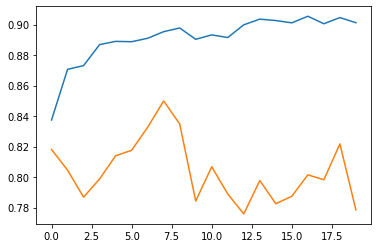

In [ ]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

train_lo = 0
train_acc = 0
test_lo = 0
test_acc = 0


for epoch in tqdm(range(EPOCHS), desc="Epochs"):
  train_lo,train_acc = train(train_dl, model, criterion, Optimizer, epoch)
  test_lo,test_acc = test(test_dl, model, criterion, Optimizer, epoch)

  train_loss.append(train_lo)
  test_loss.append(test_lo)

  train_accuracy.append(train_acc)
  test_accuracy.append(test_acc)

  print(train_loss,train_accuracy,test_loss,test_accuracy)
  

plt.plot(train_accuracy)
plt.plot(test_accuracy)

plt.show()


In [ ]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/DM_Project/model_scripted.pt')

In [ ]:
model = torch.jit.load('/content/gdrive/MyDrive/DM_Project/model_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Bottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
      (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (downsample): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=B